In [1]:
import qiskit as qk
from qiskit import execute, Aer, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram, plot_state_city, circuit_drawer

from matplotlib import pyplot as plt
import matplotlib.image as maping
import numpy as np
from math import pi

In [2]:
# 4 qubit quantum register
num_qubit = 4
q = QuantumRegister(num_qubit, 'q')
c = ClassicalRegister(num_qubit, 'c')
qc = QuantumCircuit(q,c)

In [3]:
# time interval
dt = 0.1
# number of time step
step = 40#40
# potential intensity
#v = 0
v = 40

In [4]:
def swap_register(circuit):
    for qubit in range(num_qubit//2):
        circuit.swap(qubit, num_qubit-qubit-1)

In [5]:
def QFT(circuit):
    if num_qubit == 0:
        return circuit # 여기서 함수 끝남(return)
    for qubit in reversed(range(num_qubit)):
        circuit.h(qubit)
        for position in range(qubit):
            circuit.cp(pi/2**(qubit-position), position, qubit)
    swap_register(circuit)

In [6]:
def inverse_QFT(circuit):
    swap_register(circuit)
    if num_qubit == 0:
        return circuit
    for qubit in range(num_qubit):
        circuit.h(qubit)
        for position in range(1, num_qubit-qubit):
            circuit.cp(-pi/2**(position),qubit, qubit + position)

In [7]:
# tunneling circuit
# start point
#qc.x(q[0])
#qc.x(q[1])
#qc.x(q[2])
#qc.x(q[3])
# qc.barrier()

# save list
rho_list = []
prob_list = []

# construct circuit
for i in range(step):
    # QFT
    qc.barrier()
    QFT(qc)
    qc.barrier()
    # Kinetic
    qc.rz(-(pi**2)*dt, q[3])
    qc.rz(-(pi**2)*dt/4, q[2])
    qc.rz(-(pi**2)*dt/16, q[1])
    qc.rz(-(pi**2)*dt/64, q[0])
    qc.cp(-(pi**2)*dt/16, q[0], q[1])
    qc.cp(-(pi**2)*dt/8, q[0], q[2])
    qc.cp((pi**2)*dt/4, q[0], q[3])
    qc.cp(-(pi**2)*dt/4, q[1], q[2])
    qc.cp((pi**2)*dt/2, q[1], q[3])
    qc.cp((pi**2)*dt, q[2], q[3])
    qc.barrier()
    # inverse QFT
    inverse_QFT(qc)
    qc.barrier()
    # middle potential
    qc.x(q[3])
    qc.cp(-v*dt/4, 3, 0)
    qc.cx(3,2)
    qc.cp(v*dt/4, 2, 0)
    qc.cx(3,2)
    qc.cp(-v*dt/4, 2,0)
    qc.cx(2,1)
    qc.cp(v*dt/4, 1, 0)
    qc.cx(3,1)
    qc.cp(-v*dt/4, 1, 0)
    qc.cx(2,1)
    qc.cp(v*dt/4, 1, 0)
    qc.cx(3,1)
    qc.cp(-v*dt/4, 1, 0)
    qc.x(q[3])
    qc.barrier()
    #
    qc.x([0,1,2])
    qc.cp(-v*dt/4, 3, 0)
    qc.cx(3,2)
    qc.cp(v*dt/4, 2, 0)
    qc.cx(3,2)
    qc.cp(-v*dt/4, 2,0)
    qc.cx(2,1)
    qc.cp(v*dt/4, 1, 0)
    qc.cx(3,1)
    qc.cp(-v*dt/4, 1, 0)
    qc.cx(2,1)
    qc.cp(v*dt/4, 1, 0)
    qc.cx(3,1)
    qc.cp(-v*dt/4, 1, 0)
    qc.x([0,1,2])
    qc.barrier()
    
    job = qk.execute(qc, Aer.get_backend('statevector_simulator'))
    psi = job.result().get_statevector(qc)
    rho = qk.quantum_info.DensityMatrix(psi)
    prob_list.append(np.real(np.diag(rho)))
    rho_list.append(rho)

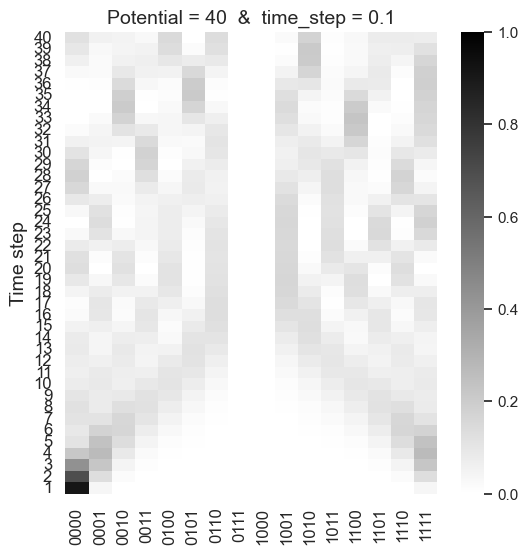

In [8]:
import seaborn as sns; sns.set_theme()

n = num_qubit
x_axis_labels =[]
for i in range(2**num_qubit):
    binary_re = bin(i)[2:]  # n=5, 0b101
    padded_bi = binary_re.zfill(n) # n =4 101 > 0101 
    x_axis_labels.append(padded_bi)
y_axis_labels = [i+1 for i in range(step)]

prob_data = prob_list
sns.set(rc = {'figure.figsize':(6,6)})
ax = sns.heatmap(
    prob_data, 
    cmap='binary', 
    xticklabels=x_axis_labels, 
    yticklabels=y_axis_labels, 
    vmin=0, vmax=1)
ax.invert_yaxis()

ax.set_title(f'Potential = {v}  &  time_step = {dt}', fontsize = 14)
plt.ylabel('Time step', fontsize = 14) 
# plt.xlabel(f'Potential = {v}, dt = {dt}', fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [138]:
# measurement
for k in range(num_qubit):
    qc.measure(k,k)

In [139]:
# backend
backend = Aer.get_backend('qasm_simulator')

# Execute
shots = 8192
job_sim = execute(qc, backend, shots=shots)
result = job_sim.result()
counts_ex = result.get_counts(qc)

print(counts_ex)

{'1000': 104, '1110': 401, '1001': 296, '1011': 466, '0100': 431, '1100': 397, '0000': 300, '0010': 494, '0110': 508, '0011': 290, '0001': 570, '0111': 1504, '0101': 543, '1111': 706, '1101': 664, '1010': 518}


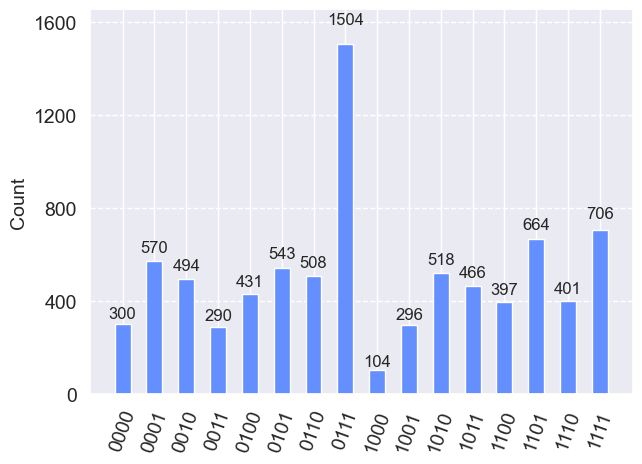

In [140]:
custom_colors = [ '#0000ff']
custom_labels = {'00': 'Zero-Zero', '01': 'Zero-One', '10': 'One-Zero', '11': 'One-One'}

# plot_histogram(counts_ex, color=custom_colors, bar_labels=custom_labels)
plot_histogram(counts_ex)

In [141]:
# 회로 그리기 (step이 크면 안됨)
#qc.draw(output='mpl', scale=1.2)

In [142]:
#----------------------- Add time dependence motion.

In [143]:
import matplotlib.pyplot as plt
from matplotlib import animation as animation, rc
from matplotlib.patches import Rectangle
rc('animation', html='html5')

In [144]:
def update(frame, xdata, data):
    #print(frame)
    line2d.set_data([xdata, data[frame]**2])
    return line2d 

In [145]:
prob_data[0]

array([3.88687080e-02, 3.13388714e-03, 6.67958867e-04, 2.46991079e-04,
       1.27259191e-04, 8.28363508e-05, 6.49720838e-05, 6.00511518e-05,
       6.49720838e-05, 8.28363508e-05, 1.27259191e-04, 2.46991079e-04,
       6.67958867e-04, 3.13388714e-03, 3.88687080e-02, 9.13554723e-01])

/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_89267/3260565519.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  xtexts = ax.set_xticklabels(x_axis_labels, rotation=90)


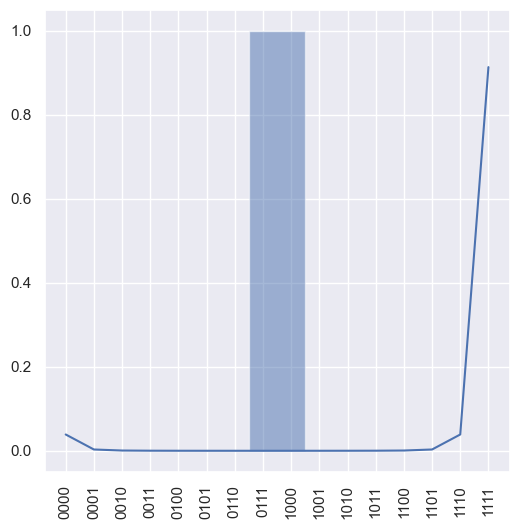

In [146]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
line2d = ax.plot(x_axis_labels, prob_data[0])[0]
#xlabel = ax.set_xlabel(x_axis_labels)
xtexts = ax.set_xticklabels(x_axis_labels, rotation=90)
ax.add_patch(Rectangle((6.5, 0), 2, 1, alpha=0.5))
#ax.set_xticks(rotation=90)


In [147]:
ani = animation.FuncAnimation(
    fig,
    func = update,
    fargs = [range(16), prob_data],
    frames = step,
    interval=1
)

In [148]:
from IPython.display import HTML

In [149]:
HTML(ani.to_jshtml())